### Make initial conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.backends.backend_pdf
import gsw
import tqdm
import sys
sys.path.append('/home/users/birgal/')
# sys.path.append('/home/birgal/Documents/antarctic/analysis/')
from nemo_python.interpolation import interp_latlon_cf, neighbours, neighbours_z, extend_into_mask
from nemo_python.utils import fix_lon_range

In [40]:
# #  File locations on laptop:
# folder_SOSE = '/home/birgal/Documents/antarctic/data/B-SOSE/'
# folder_BC   = '/home/birgal/Documents/antarctic/analysis/boundary-conditions/observational/'
# folder_NEMO = '/home/birgal/Documents/antarctic/data/bathymetry/'

# File locations on Jasmin:
folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
folder_BC   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/'
folder_NEMO = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

# Load files:
nemo = xr.open_dataset(f'{folder_NEMO}coordinates_AIS.nc').squeeze()
nemo_mask = xr.open_dataset(f'{folder_NEMO}mesh_mask-20231025.nc')
sose      = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m01.nc')
domcfg    = xr.open_dataset(f'{folder_NEMO}domain_cfg-20231025.nc')

nemo_depths = nemo_mask.nav_lev.values

#### Functions

In [41]:
# Compute edges of the z-levels
def vertical_edges(mesh, mtype='nemo'):

    if mtype=='nemo':    # 2D
        z_centres = mesh.gdept_0.isel(time_counter=0).values
        dz        = mesh.e3t_0.isel(time_counter=0).values
    elif mtype=='SOSE':  # 1D --> 2D
        z_centres, _ = xr.broadcast(-1*sose.Z, mesh[list(mesh.keys())[0]].isel(z=0))
        dz, _        = xr.broadcast(sose.drF, mesh[list(mesh.keys())[0]].isel(z=0))
        # z_centres, _ = xr.broadcast(mesh.Z, mesh.Depth.isel(YC=0,XC=slice(0,nemo.gdept_0.x.size)))
        # dz, _        = xr.broadcast(mesh.drF, mesh.Depth.isel(YC=0,XC=slice(0,nemo.gdept_0.x.size)))
        
        z_centres = z_centres.values
        dz        = dz.values
    else:
        print('Only mesh types included are nemo and SOSE')

    z_top_edge = z_centres - 0.5*dz
    z_bot_edge = z_centres + 0.5*dz
    
    z_top_edge[z_top_edge < 0] = 0
    
    return (z_top_edge, z_centres, z_bot_edge)

In [42]:
def vert_interp(SOSE_hinterp):
    
    nemo_edges = vertical_edges(nemo_mask, mtype='nemo')
    sose_edges = vertical_edges(SOSE_hinterp, mtype='SOSE')
    
    SOSE_interp = {}
    SOSE_dataset = xr.Dataset()
    
    for var in SOSE_hinterp.keys():
        print(f'Vertically interpolating variable {var}')
        model_ICs = []
        for n, ndepth in enumerate(nemo_mask.nav_lev.values):               
            # Interpolate slices from SOSE to NEMO depth levels
            data_interp = interp_depth(SOSE_hinterp[var], sose_edges, nemo_edges, n)
            # Add interpolated layers to dataset
            model_ICs.append(data_interp)

        SOSE_interp[var] = xr.concat(model_ICs, dim='z').assign_coords(z=nemo_depths)

        # fill only those cells that are nearest the bottom with nearest neighbour instead of NaN
        Var_masked = np.ma.masked_where(np.isnan(SOSE_interp[var][var].values), SOSE_interp[var][var].values)
        ind        = np.ma.notmasked_edges(Var_masked, axis=0)
        bottom_ind = ind[1][0][:] + 1 # list of Z level associated with each of the y cells

        print(Var_masked.shape)
        for i, ind in enumerate(bottom_ind):
            Var_masked[ind, 0, i] = Var_masked[ind-1, 0, i]

        SOSE_interp[var][var] = (('z','y','x'), Var_masked.data)

    return SOSE_interp

In [43]:
# Helper function to convert an xarray dataset with 3D T and S to TEOS10
# - inputs: practical salinity and potential temperature
# - returns: absolute salinity and conservative temperature
def convert_to_teos10(dataset):
    # Convert to TEOS10

    # Need 3D lat, lon, pressure at every point, so if 1D or 2D, broadcast to 3D
    if dataset.lon.values.ndim <= 2:
        lon   = xr.broadcast(dataset['lon'], dataset['potT'])[0]
    if dataset.lat.values.ndim <= 2:
        lat   = xr.broadcast(dataset['lat'], dataset['potT'])[0]
    if dataset.depth.values.ndim <= 2:
        # Need pressure in dbar at every 3D point: approx depth in m
        press = np.abs(xr.broadcast(dataset['depth'], dataset['potT'])[0])
    else:
        press = np.abs(dataset['depth'])
    
    # Get absolute salinity
    absS  = gsw.SA_from_SP(dataset['pracS'], press, lon, lat)
    
    # Get conservative temperature
    consT  = gsw.CT_from_t(absS, dataset['potT'], press)

    # dataset.assign(absS=absS)

    return absS, consT

#### Main

In [ ]:
if dataset[var].values.ndim <= 2:

else: # will need to loop over depths since 
    

In [95]:
# input:
# - source_file = '/home/birgal/Documents/antarctic/data/B-SOSE/SALT_climatology_m01.nc'
# - ndim=2 or 3 --> tells whether need to loop over depths
# - convert_TEOS10=False
salt_file = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc'
temp_file = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/THETA_climatology_m01.nc'
dataset   = 'SOSE'

### Horizontal interpolation
datasets = []

# Loop over all SOSE depth levels:
for dl in range(0,1): #sose.Z.size):
    if dataset == 'SOSE':
        name_remapping = {'XC':'lon', 'YC':'lat', 'Z':'depth'}
            
        # Read temperature and salinity from January as a single dataset, and slice to latitude range that I want to interpolate to reduce size
        SOSE_salt = xr.open_dataset(f'{salt_file}').rename(name_remapping).sel(lat=slice(-90, -48))
        SOSE_temp = xr.open_dataset(f'{temp_file}').rename(name_remapping).sel(lat=slice(-90, -48))
        
        # For SOSE, convert longitudes from 0-360 to -180 to 180 
        SOSE_temp['lon'] = fix_lon_range(SOSE_temp.lon)
        SOSE_salt['lon'] = fix_lon_range(SOSE_salt.lon)

        SOSE_temp = SOSE_temp.sortby('lon') # important to avoid a weird strip at the edges
        SOSE_salt = SOSE_salt.sortby('lon')

        # convert to TEOS10:
        SOSE = xr.Dataset({'lon':SOSE_temp['lon'], 'lat':SOSE_temp['lat'], 'depth': SOSE_temp['depth'],
                           'potT':SOSE_temp['THETA'], 'pracS':SOSE_salt['SALT']})
        SOSE_AS, SOSE_CT = convert_to_teos10(SOSE)
        
        # Now wrap up into a new Datasetd
        source = xr.Dataset({'lon':SOSE['lon'], 'lat':SOSE['lat'], 
                             'THETA': xr.where(SOSE_temp.maskC.isel(depth=dl)==1, SOSE_CT.isel(depth=dl), np.nan)}) #, 'THETA':SOSE_CT.isel(depth=0), 'salt':SOSE_SA.isel(depth=0)})
        
        # Interpolate slices of depth levels along lat-lon (horizontally)
        interp_src = interp_latlon_cf(source, nemo, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
        
        datasets.append(interp_src)

SOSE_interpolated = xr.concat(datasets, dim='z').assign_coords(z=np.abs(SOSE.depth.values[0:dl+1]))

I ran the above code snippet for horizontal interpolation of the SOSE data to the NEMO grid separately with "IC-horizintal-interp.py", and am reading in the file now to do the vertical interpolation and then filling.

In [44]:
SOSE_hinterp_salt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/salt-horizontal-interp.nc')

In [45]:
# SOSE_interpolated['THETA'] = xr.where(np.isnan(SOSE_interpolated.THETA.values), -1.9, SOSE_interpolated.THETA)
# SOSE_interpolated['THETA'] = xr.where(SOSE_interpolated.THETA.values == -1.9, np.nan, SOSE_interpolated.THETA)

In [46]:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    
    NEMO_top_edge = nemo_edges[0][n,:,:]; NEMO_bot_edge = nemo_edges[2][n,:,:];

    dataset = xr.Dataset({}) #.assign_coords(x=source.x, y=source.y)

    for var in source: # loop over the variables in the source dataset
        # find the source edges that fall within the depth ranges of the NEMO grid cells:
        Var = 0; 
        for zs in range(0,source.z.size):
            src_top_edge = source_edges[0][zs,:,:]; src_bot_edge = source_edges[2][zs,:,:];

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), 
                           Var + (NEMO_bot_edge - NEMO_top_edge)* (source.isel(z=zs)), Var)

            Var = xr.where((NEMO_top_edge >= src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_bot_edge > NEMO_top_edge), 
                           Var + (src_bot_edge - NEMO_top_edge) * source.isel(z=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (NEMO_bot_edge - src_top_edge) * source.isel(z=zs), Var)

            Var = xr.where((NEMO_top_edge < src_top_edge)*(src_bot_edge < NEMO_bot_edge)*(src_top_edge < NEMO_bot_edge), 
                           Var + (src_bot_edge - src_top_edge) * source.isel(z=zs), Var)

            # if the SOSE bottom grid cell is shallower than the WOA bottom grid cell, the value of the cell is NaN
        
        Var = Var/(NEMO_bot_edge - NEMO_top_edge)
        dataset[var] = (('y', 'x'), Var[var].values)
        
    return dataset

In [47]:
nemo_edges = vertical_edges(nemo_mask, mtype='nemo')
sose_edges = vertical_edges(SOSE_hinterp_salt, mtype='SOSE')    

SOSE_interp = {}
SOSE_dataset = xr.Dataset()
    
var='SALT'
print(f'Vertically interpolating variable {var}')
model_ICs = []
for n in tqdm.tqdm(range(len(nemo_mask.nav_lev.values))): 
    # print(f'Depth level: {n}/{len(nemo_mask.nav_lev.values)}')
    # Interpolate slices from SOSE to NEMO depth levels
    data_interp = interp_depth(SOSE_hinterp_salt, sose_edges, nemo_edges, n)
    # Add interpolated layers to dataset
    model_ICs.append(data_interp)

 # SOSE_interpolated = xr.concat(datasets, dim='z').assign_coords(z=np.abs(SOSE.depth.values[0:dl+1]))
SOSE_interp = xr.concat(model_ICs, dim='z') #.assign_coords(z=nemo_depths)

Vertically interpolating variable SALT


100%|██████████| 121/121 [05:43<00:00,  2.84s/it]


In [48]:
# fill only those cells that are nearest the bottom with nearest neighbour instead of NaN
Var_masked = np.ma.masked_where(np.isnan(SOSE_interp.SALT.values), SOSE_interp.SALT.values)
ind_array  = np.ma.notmasked_edges(Var_masked, axis=0)
bottom_ind = ind_array[1][0][:] + 1 # list of Z level associated with each of the y cells
bottom_ind[bottom_ind>=121] = 120 # max python grid value
lat_ind    = ind_array[1][1][:] 
lon_ind    = ind_array[1][2][:]

for i, bot in enumerate(bottom_ind):
    # print(bottom_ind[i], lat_ind[i], lon_ind[i])
    Var_masked[bottom_ind[i], lat_ind[i], lon_ind[i]] = Var_masked[bottom_ind[i]-1, lat_ind[i], lon_ind[i]]

SOSE_interp[var] = (('z','y','x'), Var_masked.data)

In [49]:
nemo_ocn           = (nemo_mask.tmask.isel(time_counter=0) != 0)
interp_src_tofill  = xr.where(np.isnan(SOSE_interp.SALT.values)*nemo_ocn, 1000, SOSE_interp.SALT.values)

In [50]:
theta_extended     = extend_into_mask(interp_src_tofill.values, missing_val=1000)

for iter in tqdm.tqdm(range(100)):
    theta_extended = extend_into_mask(theta_extended, missing_val=1000) # doesn't change any of the values

100%|██████████| 100/100 [11:10<00:00,  6.70s/it]


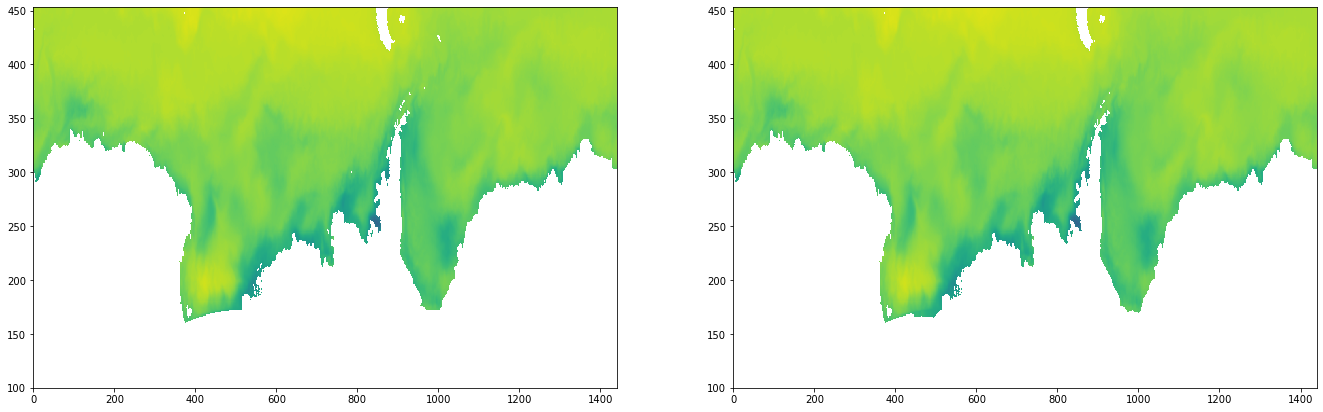

In [18]:
int=1
vminm=25
vmaxm=35
fig, ax = plt.subplots(1,2, figsize=(23,7))
ax[0].pcolormesh(SOSE_interp.SALT.isel(z=int).values, vmin=vminm, vmax=vmaxm)
ax[1].pcolormesh(theta_extended[int,:,:], vmin=vminm, vmax=vmaxm)
# ax[2].pcolormesh(theta_extended[int,:,:] - xr.where(np.isnan(SOSE_interp.SALT.isel(z=int)), 0, SOSE_interp.SALT.isel(z=int)).values, vmin=vminm, vmax=vmaxm)
# theta_plot = np.ma.masked_where(~np.isnan(interp_src.THETA.values)*nemo_ocn, theta_extended)
# ax[1].pcolormesh(theta_plot, vmin=-1, vmax=1)
# ax[1].pcolormesh(interp_src_tofill, vmin=-2, vmax=3)

for axis in ax.ravel():
    axis.set_ylim(100,453)

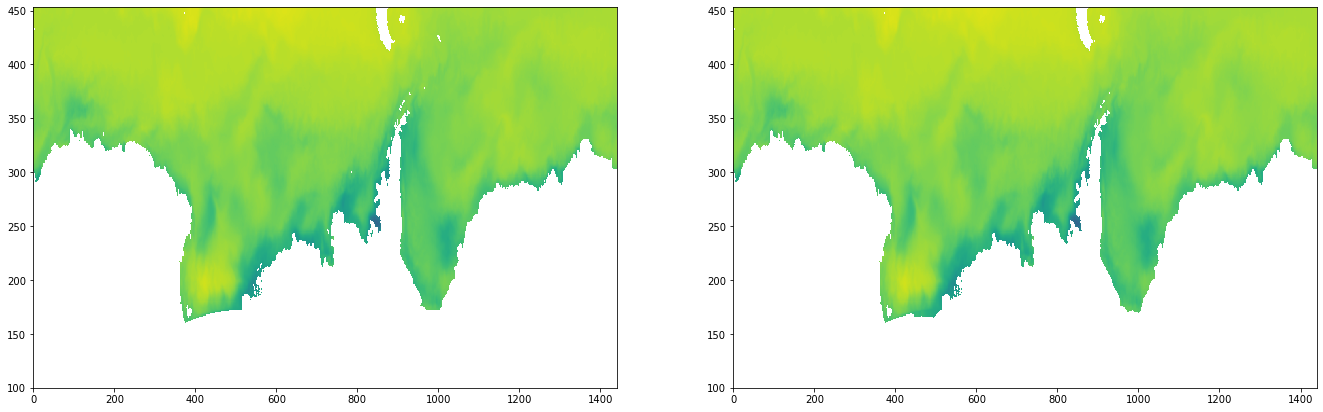

In [51]:
int=1
vminm=25
vmaxm=35
fig, ax = plt.subplots(1,2, figsize=(23,7))
ax[0].pcolormesh(SOSE_interp.SALT.isel(z=int).values, vmin=vminm, vmax=vmaxm)
ax[1].pcolormesh(theta_extended[int,:,:], vmin=vminm, vmax=vmaxm)
# ax[2].pcolormesh(theta_extended[int,:,:] - xr.where(np.isnan(SOSE_interp.SALT.isel(z=int)), 0, SOSE_interp.SALT.isel(z=int)).values, vmin=vminm, vmax=vmaxm)
# theta_plot = np.ma.masked_where(~np.isnan(interp_src.THETA.values)*nemo_ocn, theta_extended)
# ax[1].pcolormesh(theta_plot, vmin=-1, vmax=1)
# ax[1].pcolormesh(interp_src_tofill, vmin=-2, vmax=3)

for axis in ax.ravel():
    axis.set_ylim(100,453)

In [50]:
### vertical interpolation:

# SOSE_vinterpolated = vert_interp(SOSE_interpolated)

In [86]:
# source_mask = (sose.maskC == 0)
# nemo_ocn    = (nemo_mask.tmask.isel(time_counter=0, nav_lev=0) != 0)

# # in ocean cells that have NaN value, fill with 1 for now
# # xr.where(nemo_ocn and interp_src.THETA == 0, )
# mask_to_fill = xr.where(np.isnan(interp_src.THETA.values)*nemo_ocn, 1, 0) # regions that will need to be filled
# # could use numpy masked edges in subsequent loops to fill
# (mask_to_fill==1)
# for each value in the mask, select the 9 closest points from the interpolated theta and take the average of those and fill the value

In [12]:
nemo_ocn           = (nemo_mask.tmask.isel(time_counter=0, nav_lev=[0,1]) != 0)
interp_src_tofill  = xr.where(np.isnan(SOSE_interpolated.THETA.values)*nemo_ocn, 1000, SOSE_interpolated.THETA.values)

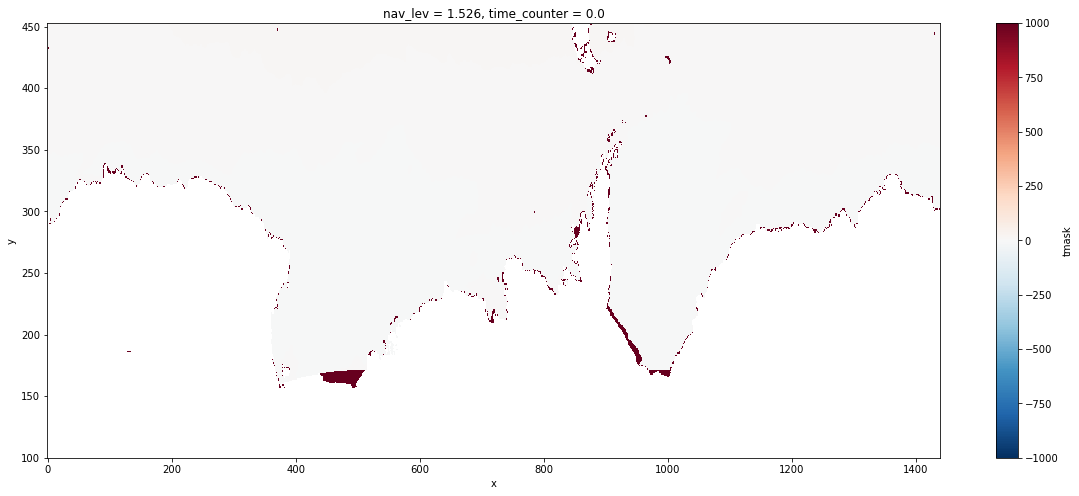

In [13]:
interp_src_tofill.isel(nav_lev=1).plot(ylim=(100,453), figsize=(20,8))

In [14]:
theta_extended     = extend_into_mask(interp_src_tofill.values, missing_val=1000)

for iter in range(0,100):
    theta_extended = extend_into_mask(theta_extended, missing_val=1000) # doesn't change any of the values

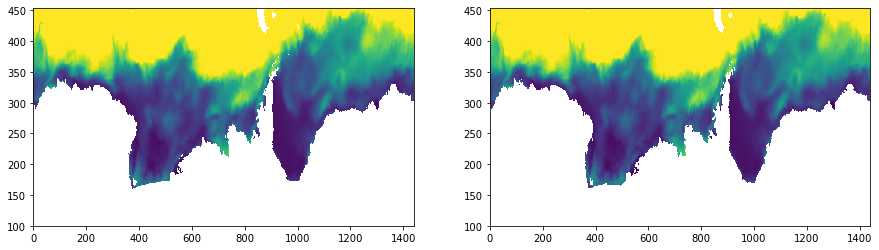

In [15]:
int=1
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].pcolormesh(SOSE_interpolated.THETA.isel(Z=int).values, vmin=-2, vmax=3)
ax[1].pcolormesh(theta_extended[int,:,:], vmin=-2, vmax=3)
# theta_plot = np.ma.masked_where(~np.isnan(interp_src.THETA.values)*nemo_ocn, theta_extended)
# ax[1].pcolormesh(theta_plot, vmin=-1, vmax=1)
# ax[1].pcolormesh(interp_src_tofill, vmin=-2, vmax=3)

for axis in ax.ravel():
    axis.set_ylim(100,453)

### Old

In [17]:
# # Helper function to convert longitudes from 0 to 360, to -180 to 180 degrees east
# # - input: xarray dataset with at least variable 'lon'
# # - output: 
# def convert_lon_360_to_180(dataset):
#     if dataset.lon.max() < 181: 
#         print('Maximum longitude in dataset was less than 180; double-check that you really wanted to convert it.')
        
#     dataset['lon'] = xr.where(dataset.lon > 180, dataset.lon - 360, dataset.lon)
#     dataset = dataset.sortby('lon')
    
#     return dataset